<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/IRC010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np  # 导入NumPy库，用于数值计算和数组操作

import torch  # 导入PyTorch库，用于构建和训练神经网络
import torch.nn as nn  # 导入PyTorch的神经网络模块
import torch.optim as optim  # 导入PyTorch的优化器模块
from sklearn.datasets import make_classification  # 从scikit-learn导入生成分类数据集的工具
from sklearn.model_selection import train_test_split  # 从scikit-learn导入划分数据集的工具
from sklearn.metrics import accuracy_score  # 从scikit-learn导入计算准确率的工具

# 生成模拟数据
X, y = make_classification(
    n_samples=10000, n_features=20, n_classes=2, n_informative=8, n_redundant=2, random_state=42
)  # 使用make_classification生成一个包含10000个样本，20个特征，2个类别的分类数据集。n_informative和n_redundant控制特征的有效性和冗余性，random_state用于控制随机性，保证结果可复现。
y_multi = np.hstack([y.reshape(-1, 1), (y ^ 1).reshape(-1, 1)])  # 创建两个相关任务。将原始标签y变形为列向量，并与y的按位异或结果组合，形成多任务学习的标签。

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi, test_size=0.2, random_state=42
)  # 将数据集划分为训练集和测试集，测试集占比20%。random_state保证划分方式可复现。

# 转换Tensor
X_train = torch.FloatTensor(X_train)  # 将训练集的特征数据转换为PyTorch的Float张量
X_test = torch.FloatTensor(X_test)  # 将测试集的特征数据转换为PyTorch的Float张量
y_train = torch.FloatTensor(y_train)  # 将训练集的标签数据转换为PyTorch的Float张量
y_test = torch.FloatTensor(y_test)  # 将测试集的标签数据转换为PyTorch的Float张量

# 定义专家网络模块
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()  # 调用父类的初始化方法
        self.fc = nn.Sequential(  # 定义一个顺序的神经网络层，包含线性层、GELU激活函数和层归一化
            nn.Linear(input_dim, output_dim),  # 线性层，将输入维度映射到输出维度
            nn.GELU(),  # GELU激活函数
            nn.LayerNorm(output_dim)  # 层归一化
        )

    def forward(self, x):
        return self.fc(x)  # 定义前向传播过程，将输入x传递给定义的神经网络层

# 定义CGC层（核心组件）
class CGC(nn.Module):
    def __init__(self, input_dim, expert_dim, num_shared_experts, num_task_experts, num_tasks):
        super().__init__()  # 调用父类的初始化方法
        self.num_tasks = num_tasks  # 任务数量

        # 共享专家
        self.shared_experts = nn.ModuleList([  # 定义共享专家列表，使用nn.ModuleList可以方便地管理多个模块
            Expert(input_dim, expert_dim) for _ in range(num_shared_experts)
        ])  # 创建num_shared_experts个共享专家，每个专家都是一个Expert实例

        # 任务专家
        self.task_experts = nn.ModuleList([  # 定义任务专家列表
            nn.ModuleList([  # 每个任务对应一个任务专家列表
                Expert(input_dim, expert_dim) for _ in range(num_task_experts)
            ]) for _ in range(num_tasks)
        ])  # 创建num_tasks个任务，每个任务有num_task_experts个任务专家

        # 门控网络
        self.gates = nn.ModuleList([  # 定义门控网络列表
            nn.Sequential(  # 每个任务对应一个门控网络
                nn.Linear(input_dim, num_shared_experts + num_task_experts),  # 线性层，将输入映射到共享专家和任务专家数量之和
                nn.Softmax(dim=-1)  # Softmax激活函数，将输出转换为概率分布
            ) for _ in range(num_tasks)
        ])  # 为每个任务创建一个门控网络

    def forward(self, x):
        # 生成所有专家输出
        shared_outputs = [expert(x) for expert in self.shared_experts]  # 获取所有共享专家的输出
        task_outputs = [  # 获取所有任务专家的输出
            [expert(x) for expert in self.task_experts[i]]
            for i in range(self.num_tasks)
        ]

        # 门控机制
        outputs = []  # 存储每个任务的输出
        for i in range(self.num_tasks):
            # 合并共享和任务专家
            all_experts = shared_outputs + task_outputs[i]  # 合并共享专家和当前任务的任务专家
            expert_tensor = torch.stack(all_experts, dim=1)  # 将所有专家输出堆叠成一个张量，维度为[batch, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](x)  # 使用门控网络计算门控权重，维度为[batch, num_experts]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)  # 使用爱因斯坦求和，对专家输出进行加权融合，维度为[batch, dim]
            outputs.append(weighted_output)  # 将加权融合后的输出添加到输出列表

        return outputs  # 返回所有任务的输出

# 定义完整PLE模型
class PLE(nn.Module):
    def __init__(self, input_dim, num_tasks, num_layers=3):
        super().__init__()  # 调用父类的初始化方法
        self.layers = nn.ModuleList()  # 定义一个CGC层列表
        self.num_tasks = num_tasks  # 任务数量

        # 构建多个CGC层
        layer_dims = [input_dim] + [64]*(num_layers-1)  # 定义CGC层的输入维度，第一层输入维度是input_dim，后续层输入维度是64
        for i in range(num_layers):
            self.layers.append(  # 循环创建CGC层，并添加到列表中
                CGC(
                    input_dim=layer_dims[i],  # 当前CGC层的输入维度
                    expert_dim=64,  # 专家网络的输出维度
                    num_shared_experts=2,  # 共享专家的数量
                    num_task_experts=2,  # 任务专家的数量
                    num_tasks=num_tasks  # 任务的数量
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList([  # 定义任务特定的塔网络
            nn.Sequential(  # 每个任务对应一个塔网络
                nn.Linear(64, 32),  # 线性层，将输入维度映射到32
                nn.ReLU(),  # ReLU激活函数
                nn.Linear(32, 1),  # 线性层，将输入维度映射到1
                nn.Sigmoid()  # Sigmoid激活函数，输出0到1之间的概率值
            ) for _ in range(num_tasks)
        ])  # 为每个任务创建一个塔网络

    def forward(self, x):
        # 修改初始化方式，确保task_outputs与layer_outputs维度匹配
        task_outputs = [torch.zeros(x.shape[0], 64, device=x.device) for _ in range(self.num_tasks)] # 初始化任务输出，维度与CGC层的输出一致

        # 逐层处理
        for layer in self.layers:
            layer_outputs = layer(x)  # 经过CGC层，得到输出
            # 更新每个任务的特征
            for i in range(self.num_tasks):
                task_outputs[i] = task_outputs[i] + layer_outputs[i]  # 将CGC层输出添加到任务输出，实现特征融合
                x = torch.stack(task_outputs).mean(dim=0)  # 共享特征更新。将所有任务的输出堆叠起来，求均值，作为下一层的输入。

        # 最终预测
        outputs = []  # 存储最终的预测结果
        for i in range(self.num_tasks):
            outputs.append(self.towers[i](task_outputs[i]))  # 将任务输出传递给塔网络，得到最终的预测结果

        return torch.cat(outputs, dim=1)  # 将所有任务的预测结果拼接起来，作为模型的输出

# 初始化模型
model = PLE(input_dim=20, num_tasks=2)  # 创建PLE模型实例，输入维度为20，任务数量为2
criterion = nn.BCELoss()  # 定义损失函数，使用二元交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 定义优化器，使用Adam优化器，学习率为0.001

# 训练循环
for epoch in range(50):  # 迭代50个epoch
    model.train()  # 将模型设置为训练模式
    optimizer.zero_grad()  # 梯度清零

    outputs = model(X_train)  # 将训练数据输入模型，得到输出
    loss1 = criterion(outputs[:, 0], y_train[:, 0])  # 计算第一个任务的损失
    loss2 = criterion(outputs[:, 1], y_train[:, 1])  # 计算第二个任务的损失
    total_loss = loss1 + loss2  # 计算总损失

    total_loss.backward()  # 反向传播，计算梯度
    optimizer.step()  # 更新模型参数

    # 验证
    model.eval()  # 将模型设置为评估模式
    with torch.no_grad():  # 关闭梯度计算
        test_outputs = model(X_test)  # 将测试数据输入模型，得到输出
        pred1 = (test_outputs[:, 0] > 0.5).float()  # 对第一个任务的输出进行二值化处理
        pred2 = (test_outputs[:, 1] > 0.5).float()  # 对第二个任务的输出进行二值化处理

        acc1 = accuracy_score(y_test[:, 0].numpy(), pred1.numpy())  # 计算第一个任务的准确率
        acc2 = accuracy_score(y_test[:, 1].numpy(), pred2.numpy())  # 计算第二个任务的准确率

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss.item():.4f} | "
          f"Task1 Acc: {acc1:.4f} | Task2 Acc: {acc2:.4f}")  # 打印每个epoch的损失和准确率


Epoch 01 | Loss: 1.3719 | Task1 Acc: 0.6445 | Task2 Acc: 0.6530
Epoch 02 | Loss: 1.3213 | Task1 Acc: 0.7160 | Task2 Acc: 0.7095
Epoch 03 | Loss: 1.2730 | Task1 Acc: 0.7530 | Task2 Acc: 0.7400
Epoch 04 | Loss: 1.2259 | Task1 Acc: 0.7735 | Task2 Acc: 0.7615
Epoch 05 | Loss: 1.1793 | Task1 Acc: 0.7800 | Task2 Acc: 0.7745
Epoch 06 | Loss: 1.1332 | Task1 Acc: 0.7885 | Task2 Acc: 0.7825
Epoch 07 | Loss: 1.0878 | Task1 Acc: 0.7915 | Task2 Acc: 0.7885
Epoch 08 | Loss: 1.0438 | Task1 Acc: 0.7960 | Task2 Acc: 0.7910
Epoch 09 | Loss: 1.0017 | Task1 Acc: 0.8030 | Task2 Acc: 0.7980
Epoch 10 | Loss: 0.9620 | Task1 Acc: 0.8090 | Task2 Acc: 0.8020
Epoch 11 | Loss: 0.9250 | Task1 Acc: 0.8155 | Task2 Acc: 0.8055
Epoch 12 | Loss: 0.8907 | Task1 Acc: 0.8145 | Task2 Acc: 0.8065
Epoch 13 | Loss: 0.8592 | Task1 Acc: 0.8145 | Task2 Acc: 0.8130
Epoch 14 | Loss: 0.8302 | Task1 Acc: 0.8200 | Task2 Acc: 0.8180
Epoch 15 | Loss: 0.8035 | Task1 Acc: 0.8245 | Task2 Acc: 0.8190
Epoch 16 | Loss: 0.7783 | Task1 Acc: 0.8

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义专家网络模块
class Expert(nn.Module):
    # 初始化专家网络模块，包含一个全连接层、GELU激活函数和LayerNorm
    def __init__(self, input_dim, output_dim):
        super(Expert, self).__init__()
        # 构建一个顺序的神经网络层，包括全连接层、GELU激活函数和LayerNorm
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),  # 全连接层
            nn.GELU(),  # GELU激活函数
            nn.LayerNorm(output_dim)  # LayerNorm
        )

    # 定义前向传播过程
    def forward(self, x):
        # 将输入x传递给定义的神经网络层
        return self.fc(x)

# 定义CGC层
class CGC(nn.Module):
    # 初始化CGC层，包含一个或多个共享专家、任务专家和门控网络
    def __init__(self, input_dim, expert_dim, num_shared_experts, num_task_experts, num_tasks):
        super(CGC, self).__init__()
        # 保存任务数量
        self.num_tasks = num_tasks

        # 定义共享专家网络
        # 创建一个包含多个专家网络的列表
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_dim) for _ in range(num_shared_experts)
        ])

        # 定义任务特定专家网络
        # 创建一个包含多个任务专家网络的列表
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_dim) for _ in range(num_task_experts)
            ]) for _ in range(num_tasks)
        ])

        # 定义门控网络
        # 创建一个包含多个门控网络的列表
        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, num_shared_experts + num_task_experts),  # 全连接层
                nn.Softmax(dim=-1)  # Softmax激活函数
            ) for _ in range(num_tasks)
        ])

    # 定义前向传播过程
    def forward(self, x):
        # 获取所有专家的输出
        # 将共享专家和任务专家的输出计算出来
        shared_outputs = [expert(x) for expert in self.shared_experts]
        task_outputs = [
            [expert(x) for expert in self.task_experts[i]]
            for i in range(self.num_tasks)
        ]

        # 门控机制，对专家输出进行加权融合
        # 初始化输出列表
        outputs = []
        # 循环处理每个任务
        for i in range(self.num_tasks):
            # 合并共享专家和任务特定专家的输出
            all_experts = shared_outputs + task_outputs[i]
            # 将所有专家的输出堆叠成一个张量
            expert_tensor = torch.stack(all_experts, dim=1)

            # 计算门控权重
            gate_weights = self.gates[i](x)

            # 加权融合专家输出
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            # 将加权融合后的输出添加到输出列表中
            outputs.append(weighted_output)

        # 返回所有任务的输出
        return outputs

# 定义PLE模型
class PLE(nn.Module):
    # 初始化PLE模型，包含一个或多个CGC层和任务特定塔网络
    def __init__(self, input_dim, num_tasks, num_layers=2, expert_dim=64,
                 num_shared_experts=2, num_task_experts=2):
        super(PLE, self).__init__()
        # 保存任务数量
        self.num_tasks = num_tasks

        # 构建多个CGC层
        self.layers = nn.ModuleList()
        # 定义CGC层的输入和输出维度
        layer_dims = [input_dim] + [expert_dim]*(num_layers-1)
        # 循环构建CGC层
        for i in range(num_layers):
            self.layers.append(
                CGC(
                    input_dim=layer_dims[i],
                    expert_dim=expert_dim,
                    num_shared_experts=num_shared_experts,
                    num_task_experts=num_task_experts,
                    num_tasks=num_tasks
                )
            )

        # 任务特定塔网络
        # 创建一个包含多个任务塔网络的列表
        self.towers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, expert_dim // 2),
                nn.ReLU(),
                nn.Linear(expert_dim // 2, 1),
                nn.Sigmoid()
            ) for _ in range(num_tasks)
        ])

    # 定义前向传播过程
    def forward(self, x):
        # 初始化任务输出
        task_outputs = [torch.zeros(x.shape[0], self.layers[0].shared_experts[0].fc[0].out_features, device=x.device) for _ in range(self.num_tasks)]
        # 逐层处理
        for layer in self.layers:
            # 将当前输入传递给CGC层，得到输出
            layer_outputs = layer(x)
            # 更新每个任务的特征
            for i in range(self.num_tasks):
                task_outputs[i] = task_outputs[i] + layer_outputs[i]
                # 更新共享特征
                x = torch.stack(task_outputs).mean(dim=0)
        # 最终预测
        # 初始化输出列表
        outputs = []
        # 循环处理每个任务
        for i in range(self.num_tasks):
            # 将任务输出传递给任务塔网络，得到预测结果
            outputs.append(self.towers[i](task_outputs[i]))
        # 将所有任务的预测结果拼接起来
        return torch.cat(outputs, dim=1)


In [3]:
import torch  # 导入PyTorch库
import torch.nn as nn  # 导入PyTorch的神经网络模块
import torch.optim as optim  # 导入PyTorch的优化器模块
from sklearn.datasets import make_classification  # 从sklearn导入生成分类数据集的函数
from sklearn.model_selection import train_test_split  # 从sklearn导入划分数据集的函数
from sklearn.metrics import accuracy_score  # 从sklearn导入计算准确率的函数

# 生成模拟数据
X, y = make_classification(n_samples=10000, n_features=20, n_classes=2,  # 生成一个包含10000个样本，20个特征，2个类别的分类数据集
                           n_informative=8, n_redundant=2, random_state=42)  # n_informative, n_redundant控制特征的有效性和冗余性，random_state用于控制随机性，保证结果可复现
# 创建多任务标签，将原始标签y和它的按位异或结果拼接成一个矩阵
y_multi = torch.tensor(np.hstack([y.reshape(-1, 1), (y ^ 1).reshape(-1, 1)]), dtype=torch.float32)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(  # 将数据集划分为训练集和测试集
    X, y_multi, test_size=0.2, random_state=42  # 测试集占比20%，random_state保证划分方式可复现
)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)  # 将训练集特征转换为PyTorch的float32张量
X_test = torch.tensor(X_test, dtype=torch.float32)  # 将测试集特征转换为PyTorch的float32张量
y_train = torch.tensor(y_train, dtype=torch.float32)  # 将训练集标签转换为PyTorch的float32张量
y_test = torch.tensor(y_test, dtype=torch.float32)  # 将测试集标签转换为PyTorch的float32张量


# 初始化模型、损失函数和优化器
model = PLE(input_dim=20, num_tasks=2)  # 创建PLE模型实例，输入维度为20，任务数为2
criterion = nn.BCELoss()  # 定义损失函数，使用二元交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 定义优化器，使用Adam优化器，学习率为0.001

# 训练循环
for epoch in range(50):  # 迭代50个epoch
    model.train()  # 将模型设置为训练模式
    optimizer.zero_grad()  # 梯度清零

    outputs = model(X_train)  # 将训练数据输入模型，得到输出
    loss1 = criterion(outputs[:, 0], y_train[:, 0])  # 计算第一个任务的损失
    loss2 = criterion(outputs[:, 1], y_train[:, 1])  # 计算第二个任务的损失
    total_loss = loss1 + loss2  # 计算总损失

    total_loss.backward()  # 反向传播，计算梯度
    optimizer.step()  # 更新模型参数

    # 验证
    model.eval()  # 将模型设置为评估模式
    with torch.no_grad():  # 关闭梯度计算
        test_outputs = model(X_test)  # 将测试数据输入模型，得到输出
        pred1 = (test_outputs[:, 0] > 0.5).float()  # 对第一个任务的输出进行二值化处理
        pred2 = (test_outputs[:, 1] > 0.5).float()  # 对第二个任务的输出进行二值化处理

        acc1 = accuracy_score(y_test[:, 0].cpu().numpy(), pred1.cpu().numpy())  # 计算第一个任务的准确率
        acc2 = accuracy_score(y_test[:, 1].cpu().numpy(), pred2.cpu().numpy())  # 计算第二个任务的准确率

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss.item():.4f} | "
          f"Task1 Acc: {acc1:.4f} | Task2 Acc: {acc2:.4f}")  # 打印每个epoch的损失和准确率


<ipython-input-3-6d8d2cab176f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)  # 将训练集标签转换为PyTorch的float32张量
<ipython-input-3-6d8d2cab176f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)  # 将测试集标签转换为PyTorch的float32张量


Epoch 01 | Loss: 1.3833 | Task1 Acc: 0.5705 | Task2 Acc: 0.6110
Epoch 02 | Loss: 1.3578 | Task1 Acc: 0.6275 | Task2 Acc: 0.6720
Epoch 03 | Loss: 1.3330 | Task1 Acc: 0.6765 | Task2 Acc: 0.7130
Epoch 04 | Loss: 1.3085 | Task1 Acc: 0.7055 | Task2 Acc: 0.7405
Epoch 05 | Loss: 1.2842 | Task1 Acc: 0.7315 | Task2 Acc: 0.7590
Epoch 06 | Loss: 1.2598 | Task1 Acc: 0.7415 | Task2 Acc: 0.7690
Epoch 07 | Loss: 1.2349 | Task1 Acc: 0.7540 | Task2 Acc: 0.7775
Epoch 08 | Loss: 1.2097 | Task1 Acc: 0.7640 | Task2 Acc: 0.7830
Epoch 09 | Loss: 1.1839 | Task1 Acc: 0.7710 | Task2 Acc: 0.7860
Epoch 10 | Loss: 1.1577 | Task1 Acc: 0.7735 | Task2 Acc: 0.7875
Epoch 11 | Loss: 1.1310 | Task1 Acc: 0.7770 | Task2 Acc: 0.7885
Epoch 12 | Loss: 1.1041 | Task1 Acc: 0.7810 | Task2 Acc: 0.7920
Epoch 13 | Loss: 1.0770 | Task1 Acc: 0.7875 | Task2 Acc: 0.7965
Epoch 14 | Loss: 1.0500 | Task1 Acc: 0.7895 | Task2 Acc: 0.7980
Epoch 15 | Loss: 1.0231 | Task1 Acc: 0.7925 | Task2 Acc: 0.8015
Epoch 16 | Loss: 0.9967 | Task1 Acc: 0.7

In [4]:
import torch  # 导入 PyTorch 库
import torch.nn as nn  # 导入 PyTorch 的神经网络模块
import torch.nn.functional as F  # 导入 PyTorch 的函数式接口

class Expert(nn.Module):
    """
    专家网络模块。

    这个模块定义了一个多层感知机 (MLP)，用于提取输入特征。
    它由多个线性层、激活函数、批归一化和 dropout 层组成。
    """
    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        """
        初始化专家网络。

        参数：
            input_dim (int): 输入特征的维度。
            hidden_units (list of int): 隐藏层神经元数量的列表。
            activation (str): 激活函数类型，可以是 'relu' 或 'gelu'。
            dropout (float): dropout 的概率。
            use_bn (bool): 是否使用批归一化。
            init_std (float): 权重初始化标准差。
        """
        super().__init__()
        self.layers = nn.ModuleList()  # 创建一个ModuleList来存储网络层
        input_size = input_dim  # 初始化输入维度
        for units in hidden_units:  # 遍历隐藏层神经元数量
            self.layers.append(nn.Linear(input_size, units))  # 添加线性层
            if use_bn:  # 如果使用批归一化
                self.layers.append(nn.BatchNorm1d(units))  # 添加批归一化层
            if activation == 'relu':  # 如果激活函数是 ReLU
                self.layers.append(nn.ReLU())  # 添加 ReLU 激活层
            elif activation == 'gelu':  # 如果激活函数是 GELU
                self.layers.append(nn.GELU())  # 添加 GELU 激活层
            if dropout > 0:  # 如果 dropout 概率大于 0
                self.layers.append(nn.Dropout(dropout))  # 添加 Dropout 层
            input_size = units  # 更新输入维度，作为下一层的输入

        # 参数初始化
        for layer in self.layers:  # 遍历网络层
            if isinstance(layer, nn.Linear):  # 如果是线性层
                nn.init.normal_(layer.weight, std=init_std)  # 初始化权重为正态分布
                if layer.bias is not None:  # 如果有偏置
                    nn.init.constant_(layer.bias, 0)  # 初始化偏置为 0

    def forward(self, x):
        """
        前向传播过程。

        参数：
            x (torch.Tensor): 输入张量。

        返回：
            torch.Tensor: 输出张量。
        """
        for layer in self.layers:  # 遍历网络层
            x = layer(x)  # 将输入 x 传入每一层
        return x  # 返回输出

class CGCLayer(nn.Module):
    """
    自定义门控组合层 (CGC Layer)。

    这个模块实现了 CGC 结构，它结合了共享专家和任务特定专家，
    并通过门控网络来组合它们的输出。
    """
    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        """
        初始化 CGC 层。

        参数：
            input_dim (int): 输入特征的维度。
            num_tasks (int): 任务的数量。
            shared_expert_num (int): 共享专家的数量。
            specific_expert_num (int): 任务特定专家的数量。
            expert_hidden_units (list of int): 专家网络的隐藏层单元数量。
            gate_hidden_units (list of int): 门控网络的隐藏层单元数量。
            activation (str): 激活函数类型，可以是 'relu' 或 'gelu'。
            dropout (float): dropout 的概率。
            use_bn (bool): 是否使用批归一化。
            init_std (float): 权重初始化标准差。
        """
        super().__init__()
        self.num_tasks = num_tasks  # 保存任务数量
        self.shared_expert_num = shared_expert_num  # 保存共享专家数量
        self.specific_expert_num = specific_expert_num  # 保存任务特定专家数量
        self.expert_hidden_units = expert_hidden_units # 存储专家网络的隐藏层单元数量

        # 任务特定专家
        self.task_experts = nn.ModuleList([  # 创建一个 ModuleList 存储任务特定专家
            nn.ModuleList([  # 为每个任务创建一个 ModuleList 存储该任务的专家
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)  # 创建专家网络
                for _ in range(specific_expert_num)  # 循环创建任务特定专家，数量为 specific_expert_num
            ]) for _ in range(num_tasks)  # 循环创建任务特定专家的ModuleList，数量为 num_tasks
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([  # 创建一个 ModuleList 存储共享专家
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)  # 创建共享专家网络
            for _ in range(shared_expert_num)  # 循环创建共享专家，数量为 shared_expert_num
        ])

        # 门控网络 - 根据专家隐藏单元调整输入维度
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 门控网络的输入维度，如果专家有隐藏层，则为最后一层的输出，否则为输入维度
        self.gates = nn.ModuleList([  # 创建一个 ModuleList 存储门控网络
            nn.Sequential(  # 创建一个序列模型
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),  # 专家网络
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),  # 线性层，输出维度为 任务特定专家数量 + 共享专家数量
                nn.Softmax(dim=-1)  # Softmax 层，对输出进行归一化
            ) for _ in range(num_tasks)  # 循环创建门控网络，数量为 num_tasks
        ])

        # 共享门控网络 - 根据专家隐藏单元调整输入维度
        self.shared_gate = nn.Sequential(  # 创建一个序列模型，用于共享门控
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),  # 专家网络
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),  # 线性层，输出维度为 任务数量 * 任务特定专家数量 + 共享专家数量
            nn.Softmax(dim=-1)  # Softmax 层，对输出进行归一化
        )

    def forward(self, task_inputs, shared_input):
        """
        前向传播过程。

        参数：
            task_inputs (list of torch.Tensor): 每个任务的输入张量列表。
            shared_input (torch.Tensor): 共享输入张量。

        返回：
            tuple: 包含任务输出和共享输出的元组。
        """
        # 任务特定专家输出
        task_expert_outputs = []  # 存储任务特定专家的输出
        for i in range(self.num_tasks):  # 遍历每个任务
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 获取该任务的专家网络的输出， 使用task_inputs[i]作为输入
            task_expert_outputs.extend(task_experts)  # 将输出添加到列表中

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]  # 共享专家输出

        # 任务门控
        task_outputs = []  # 存储每个任务的输出
        for i in range(self.num_tasks):  # 遍历每个任务
            # 组合专家输出
            experts = task_expert_outputs[i*self.specific_expert_num:(i+1)*self.specific_expert_num]  # 获取该任务的特定专家输出
            experts += shared_expert_outputs  # 将共享专家的输出添加到列表中
            expert_tensor = torch.stack(experts, dim=1)  # 将专家输出堆叠成张量，维度为 [B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # 获取该任务的门控网络的输出，输入为task_inputs[i]， 维度为 [B, num_experts]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)  #  加权融合专家输出，维度为 [B, dim]
            task_outputs.append(weighted_output)  # 将加权融合后的输出添加到列表中

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs  # 组合所有专家输出
        expert_tensor = torch.stack(all_experts, dim=1)  # 将所有专家输出堆叠成张量，维度为 [B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)  # 计算共享门控权重

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)  #  加权融合所有专家输出，得到共享输出

        return task_outputs, shared_output  # 返回任务输出和共享输出

class PLE(nn.Module):
    """
    渐进式分层抽取网络 (PLE)。

    PLE 模型是一种多任务学习模型，它通过共享专家、任务特定专家和门控网络
    来实现任务之间的知识共享和差异化学习。
    """
    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        """
        初始化 PLE 模型。

        参数：
            input_dim (int): 输入特征的维度。
            num_tasks (int): 任务的数量。
            num_levels (int): CGC 层的数量。
            shared_expert_num (int): 共享专家的数量。
            specific_expert_num (int): 任务特定专家的数量。
            expert_hidden_units (list of int): 专家网络的隐藏层单元数量。
            tower_hidden_units (list of int): 塔网络的隐藏层单元数量。
            gate_hidden_units (list of int): 门控网络的隐藏层单元数量。
            activation (str): 激活函数类型，可以是 'relu' 或 'gelu'。
            dropout (float): dropout 的概率。
            use_bn (bool): 是否使用批归一化。
            task_types (tuple of str): 每个任务的类型，可以是 'binary' 或其他。
            init_std (float): 权重初始化标准差。
        """
        super().__init__()
        self.num_tasks = num_tasks  # 保存任务数量
        self.num_levels = num_levels  # 保存CGC层的数量

        # 构建多层CGC
        self.cgc_layers = nn.ModuleList()  # 创建一个 ModuleList 存储 CGC 层
        for level in range(num_levels):  # 循环创建 CGC 层
            self.cgc_layers.append(
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1] , # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList()  # 创建一个 ModuleList 存储塔网络
        for i in range(num_tasks):  # 循环创建塔网络，数量为 num_tasks
            tower = nn.Sequential(  # 创建一个序列模型
                Expert(
                    input_dim=expert_hidden_units[-1], # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1) #  线性层输入
            )
            self.towers.append(tower)  # 将塔网络添加到列表中

        # 输出激活函数
        self.task_activations = nn.ModuleList([  # 创建一个 ModuleList 存储任务激活函数
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()  # 如果任务是二分类，使用 Sigmoid，否则使用 Identity
            for task_type in task_types  # 循环创建激活函数，数量为 task_types
        ])

    def forward(self, x):
        """
        前向传播过程。

        参数：
            x (torch.Tensor): 输入张量。

        返回：
            torch.Tensor: 输出张量。
        """
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]  #  为每个任务复制输入张量
        shared_input = x.clone()  #  复制输入张量作为共享输入

        # 逐层处理
        for cgc_layer in self.cgc_layers:  # 遍历 CGC 层
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)  # 将输入传递给 CGC 层，得到任务输出和共享输出
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input #  这里不使用残差连接

        # 最终预测
        outputs = []  # 存储最终输出
        for i in range(self.num_tasks):  # 遍历每个任务
            logit = self.towers[i](task_inputs[i])  # 将任务输入传递给塔网络，得到 logits
            output = self.task_activations[i](logit)  #  使用任务特定的激活函数，得到输出
            outputs.append(output)  # 将输出添加到列表中

        return torch.cat(outputs, dim=1)  #  将所有任务的输出拼接起来，返回

# 使用示例
if __name__ == "__main__":
    # 模拟数据
    batch_size = 32  # 批大小
    input_dim = 20  # 输入特征维度
    num_tasks = 2  # 任务数量

    # 初始化模型
    model = PLE(  # 创建 PLE 模型实例
        input_dim=input_dim,  # 输入特征维度
        num_tasks=num_tasks,  # 任务数量
        num_levels=2,  # CGC 层数
        shared_expert_num=2,  # 共享专家数量
        specific_expert_num=1,  # 任务特定专家数量
        expert_hidden_units=(256, 128),  # 专家网络隐藏层单元数
        tower_hidden_units=(64,),  # 塔网络隐藏层单元数
        gate_hidden_units=(128,),  # 门控网络隐藏层单元数
        dropout=0.2,  # dropout 概率
        use_bn=True,  # 是否使用批归一化
        task_types=('binary', 'binary')  # 任务类型
    )

    # 测试前向传播
    x = torch.randn(batch_size, input_dim)  # 生成随机输入
    outputs = model(x)  # 进行前向传播
    print(f"Output shape: {outputs.shape}")  # 打印输出的形状

    # 训练设置
    criterion = nn.BCELoss()  # 定义损失函数，使用二元交叉熵损失
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # 定义优化器，使用 Adam 优化器，学习率为 0.001

    # 模拟训练步骤
    y_true = torch.randint(0, 2, (batch_size, num_tasks)).float()  # 生成随机标签
    preds = model(x)  # 进行前向传播
    loss = sum([criterion(preds[:, i], y_true[:, i]) for i in range(num_tasks)])  # 计算损失

    optimizer.zero_grad()  # 梯度清零
    loss.backward()  # 反向传播
    optimizer.step()  # 更新模型参数
    print(f"Training loss: {loss.item():.4f}")  # 打印训练损失


Output shape: torch.Size([32, 2])
Training loss: 1.3880


In [5]:
import torch  # 导入PyTorch库
import torch.nn as nn  # 导入PyTorch的神经网络模块
import torch.nn.functional as F  # 导入PyTorch的函数模块
import numpy as np  # 导入NumPy库
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # 导入sklearn的标准化和独热编码器
from sklearn.compose import ColumnTransformer  # 导入sklearn的列转换器
import pandas as pd  # 导入 pandas


class Expert(nn.Module):
    """
    专家网络模块。

    该模块定义了一个多层感知机（MLP），作为PLE模型中的专家。
    """

    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        """
        初始化专家网络。

        参数:
            input_dim (int): 输入特征的维度。
            hidden_units (list of int): 隐藏层单元的数量。例如，[256, 128]表示两个隐藏层，分别有256和128个单元。
            activation (str): 激活函数类型，可以是 'relu' 或 'gelu'。
            dropout (float): dropout的概率。
            use_bn (bool): 是否使用批归一化。
            init_std (float): 权重初始化的标准差。
        """
        super().__init__()
        self.layers = nn.ModuleList()  # 使用ModuleList存储神经网络层
        input_size = input_dim  # 设置输入大小，初始为输入特征的维度
        for units in hidden_units:  # 遍历隐藏层单元
            self.layers.append(nn.Linear(input_size, units))  # 添加线性层
            if use_bn:  # 如果使用批归一化
                self.layers.append(nn.BatchNorm1d(units))  # 添加批归一化层
            if activation == 'relu':  # 如果激活函数是ReLU
                self.layers.append(nn.ReLU())  # 添加ReLU激活函数
            elif activation == 'gelu':  # 如果激活函数是GELU
                self.layers.append(nn.GELU())  # 添加GELU激活函数
            if dropout > 0:  # 如果dropout概率大于0
                self.layers.append(nn.Dropout(dropout))  # 添加Dropout层
            input_size = units  # 更新输入大小，用于下一层

        # 参数初始化
        for layer in self.layers:  # 遍历所有层
            if isinstance(layer, nn.Linear):  # 如果是线性层
                nn.init.normal_(layer.weight, std=init_std)  # 使用正态分布初始化权重
                if layer.bias is not None:  # 如果有偏置项
                    nn.init.constant_(layer.bias, 0)  # 将偏置项初始化为0

    def forward(self, x):
        """
        专家网络的前向传播。

        参数:
            x (torch.Tensor): 输入张量。

        返回:
            torch.Tensor: 经过专家网络处理后的输出。
        """
        for layer in self.layers:  # 遍历每一层
            x = layer(x)  # 将输入传递到当前层
        return x  # 返回输出


class CGCLayer(nn.Module):
    """
    自定义门控组合层（CGC Layer）。

    该层是PLE模型的核心，用于组合专家网络的输出。
    """

    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        """
        初始化CGC层。

        参数:
            input_dim (int): 输入特征的维度。
            num_tasks (int): 任务的数量。
            shared_expert_num (int): 共享专家的数量。
            specific_expert_num (int): 特定于任务的专家的数量。
            expert_hidden_units (list of int): 专家网络的隐藏层单元数量。
            gate_hidden_units (list of int): 门控网络的隐藏层单元数量。
            activation (str): 激活函数类型。
            dropout (float): dropout的概率。
            use_bn (bool): 是否使用批归一化。
            init_std (float): 权重初始化的标准差。
        """
        super().__init__()
        self.num_tasks = num_tasks  # 存储任务数量
        self.shared_expert_num = shared_expert_num  # 存储共享专家数量
        self.specific_expert_num = specific_expert_num  # 存储特定专家数量
        self.expert_hidden_units = expert_hidden_units  # 存储专家网络的隐藏层单元

        # 任务特定专家
        self.task_experts = nn.ModuleList([  # 创建任务特定专家列表
            nn.ModuleList([  # 为每个任务创建专家子列表
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
                for _ in range(specific_expert_num)  # 为每个任务创建指定数量的专家
            ]) for _ in range(num_tasks)  # 为每个任务创建专家
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([  # 创建共享专家列表
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
            for _ in range(shared_expert_num)  # 创建指定数量的共享专家
        ])

        # 门控网络 - adjust input dim based on expert hidden units
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 输入维度需要与专家网络输出一致
        self.gates = nn.ModuleList([  # 创建门控网络列表，每个任务一个门控网络
            nn.Sequential(  # 使用Sequential定义门控网络
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),  # 门控网络的前向网络
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),  # 线性层，输出门控权重
                nn.Softmax(dim=-1)  # Softmax层，将输出转换为概率
            ) for _ in range(num_tasks)  # 为每个任务创建门控网络
        ])

        # 共享门控网络 - adjust input dim based on expert hidden units
        self.shared_gate = nn.Sequential(  # 定义共享门控网络
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),  # 门控网络的前向网络
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),  # 线性层，输出共享门控权重
            nn.Softmax(dim=-1)  # Softmax层，将输出转换为概率
        )

    def forward(self, task_inputs, shared_input):
        """
        CGC层的前向传播。

        参数:
            task_inputs (list of torch.Tensor): 每个任务的输入张量列表。
            shared_input (torch.Tensor): 共享输入张量。

        返回:
            tuple: 包含任务输出和共享输出的元组。
        """
        # 任务特定专家输出
        task_expert_outputs = []  # 存储任务特定专家的输出
        for i in range(self.num_tasks):  # 遍历每个任务
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 每个任务的特定专家输出
            task_expert_outputs.extend(task_experts)  # 将输出添加到列表中

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]  # 共享专家的输出

        # 任务门控
        task_outputs = []  # 存储每个任务的输出
        for i in range(self.num_tasks):  # 遍历每个任务
            # 组合专家输出
            experts = task_expert_outputs[i * self.specific_expert_num:(i + 1) * self.specific_expert_num]  # 获取特定于任务的专家输出
            experts += shared_expert_outputs  # 添加共享专家输出
            expert_tensor = torch.stack(experts, dim=1)  # 堆叠专家输出，形状为[B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # 计算门控权重，形状为[B, num_experts] 输入更改为task_inputs[i]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)  # 加权融合专家输出，形状为[B, dim]
            task_outputs.append(weighted_output)  # 将输出添加到列表中

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs  # 所有专家输出
        expert_tensor = torch.stack(all_experts, dim=1)  # 堆叠所有专家输出，形状为[B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)  # 计算共享门控权重

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)  # 加权融合所有专家输出，形状为[B, dim]

        return task_outputs, shared_output  # 返回任务输出和共享输出


class PLE(nn.Module):
    """
    渐进式分层抽取网络（PLE）。

    该模型通过多层CGC层实现渐进式特征抽取和组合，用于多任务学习。
    """

    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        """
        初始化PLE模型。

        参数:
            input_dim (int): 输入特征的维度。
            num_tasks (int): 任务的数量。
            num_levels (int): CGC层的数量。
            shared_expert_num (int): 共享专家的数量。
            specific_expert_num (int): 特定于任务的专家的数量。
            expert_hidden_units (tuple of int): 专家网络的隐藏层单元数量。
            tower_hidden_units (tuple of int): 塔网络的隐藏层单元数量。
            gate_hidden_units (tuple of int): 门控网络的隐藏层单元数量。
            activation (str): 激活函数类型。
            dropout (float): dropout的概率。
            use_bn (bool): 是否使用批归一化。
            task_types (tuple of str): 任务类型，'binary'表示二分类，其他表示回归。
            init_std (float): 权重初始化的标准差。
        """
        super().__init__()
        self.num_tasks = num_tasks  # 存储任务数量
        self.num_levels = num_levels  # 存储CGC层数量

        # 构建多层CGC
        self.cgc_layers = nn.ModuleList()  # 创建CGC层列表
        for level in range(num_levels):  # 遍历每个CGC层
            self.cgc_layers.append(  # 添加CGC层
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1],
                    # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList()  # 创建塔网络列表
        for i in range(num_tasks):  # 遍历每个任务
            tower = nn.Sequential(  # 定义塔网络
                Expert(
                    input_dim=expert_hidden_units[-1],  # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1)  # 线性层输入
            )
            self.towers.append(tower)  # 添加塔网络

        # 输出激活函数
        self.task_activations = nn.ModuleList([  # 创建输出激活函数列表
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()  # 如果是二分类任务，使用Sigmoid，否则使用Identity
            for task_type in task_types  # 根据任务类型设置激活函数
        ])

    def forward(self, x):
        """
        PLE模型的前向传播。

        参数:
            x (torch.Tensor): 输入张量。

        返回:
            torch.Tensor: 模型的输出，每个任务的预测值。
        """
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]  # 为每个任务复制输入
        shared_input = x.clone()  # 复制输入作为共享输入

        # 逐层处理
        for cgc_layer in self.cgc_layers:  # 遍历每个CGC层
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)  # 通过CGC层
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input

        # 最终预测
        outputs = []  # 存储模型的输出
        for i in range(self.num_tasks):  # 遍历每个任务
            logit = self.towers[i](task_inputs[i])  # 通过塔网络得到logit
            output = self.task_activations[i](logit)  # 通过激活函数得到输出
            outputs.append(output)  # 将输出添加到列表中

        return torch.cat(outputs, dim=1)  # 拼接所有任务的输出，返回


# 使用示例
if __name__ == "__main__":
    # 模拟数据
    batch_size = 32
    # 模拟的输入特征，包括连续特征和离散特征
    # 连续特征: 'age', 'income'
    # 离散特征: 'gender', 'city'

    # 生成模拟数据
    np.random.seed(42)
    data = {
        'age': np.random.randint(18, 65, batch_size),  # 连续
        'income': np.random.normal(50000, 20000, batch_size),  # 连续
        'gender': np.random.choice(['Male', 'Female'], batch_size),  # 离散
        'city': np.random.choice(['New York', 'London', 'Paris'], batch_size)  # 离散
    }

    # 数据预处理
    # 1. 连续特征: 标准化
    # 2. 离散特征: One-Hot 编码

    # 将数据转换为 Pandas DataFrame
    df = pd.DataFrame(data)

    # 定义预处理流程
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['age', 'income']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['gender', 'city'])
        ],
        remainder='passthrough'  # 保持未指定的列
    )

    # 拟合和转换数据
    processed_data = preprocessor.fit_transform(df)  # 使用 DataFrame

    # 计算输入维度，one-hot后的维度
    input_dim = processed_data.shape[1]

    # 将数据转换为PyTorch张量
    x = torch.tensor(processed_data, dtype=torch.float32)

    num_tasks = 2

    # 初始化模型
    model = PLE(
        input_dim=input_dim,
        num_tasks=num_tasks,
        num_levels=2,
        shared_expert_num=2,
        specific_expert_num=1,
        expert_hidden_units=(256, 128),
        tower_hidden_units=(64,),
        gate_hidden_units=(128,),
        dropout=0.2,
        use_bn=True,
        task_types=('binary', 'binary')
    )

    # 测试前向传播
    outputs = model(x)
    print(f"Output shape: {outputs.shape}")  # [32, 2]

    # 训练设置
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 模拟训练步骤
    y_true = torch.randint(0, 2, (batch_size, num_tasks)).float()
    preds = model(x)
    loss = sum([criterion(preds[:, i], y_true[:, i]) for i in range(num_tasks)])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Training loss: {loss.item():.4f}")


Output shape: torch.Size([32, 2])
Training loss: 1.3829


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets  # 导入 datasets
import numpy as np
import os  # 导入 os

# 1. 定义 PLE 模型 (保持不变)
class Expert(nn.Module):
    """专家网络模块"""

    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        """
        初始化专家网络。

        Args:
            input_dim (int): 输入特征的维度。
            hidden_units (list of int): 隐藏层的单元数列表。
            activation (str): 激活函数类型，默认为 'relu'。
            dropout (float): dropout 概率，默认为 0。
            use_bn (bool): 是否使用批量归一化，默认为 False。
            init_std (float): 权重初始化标准差，默认为 1e-4。
        """
        super().__init__()
        self.layers = nn.ModuleList()
        input_size = input_dim
        for units in hidden_units:
            self.layers.append(nn.Linear(input_size, units))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(units))
            if activation == 'relu':
                self.layers.append(nn.ReLU())
            elif activation == 'gelu':
                self.layers.append(nn.GELU())
            if dropout > 0:
                self.layers.append(nn.Dropout(dropout))
            input_size = units  # 更新下一层的输入大小

        # 参数初始化
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=init_std)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        """
        前向传播。

        Args:
            x (torch.Tensor): 输入张量。

        Returns:
            torch.Tensor: 输出张量。
        """
        for layer in self.layers:
            x = layer(x)
        return x


class CGCLayer(nn.Module):
    """自定义门控组合层"""

    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        """
        初始化 CGC 层。

        Args:
            input_dim (int): 输入特征的维度。
            num_tasks (int): 任务数量。
            shared_expert_num (int): 共享专家数量。
            specific_expert_num (int): 任务特定专家数量。
            expert_hidden_units (list of int): 专家网络的隐藏单元列表。
            gate_hidden_units (list of int): 门控网络的隐藏单元列表。
            activation (str): 激活函数类型，默认为 'relu'。
            dropout (float): dropout 概率，默认为 0。
            use_bn (bool): 是否使用批量归一化，默认为 False。
            init_std (float): 权重初始化标准差，默认为 1e-4。
        """
        super().__init__()
        self.num_tasks = num_tasks
        self.shared_expert_num = shared_expert_num
        self.specific_expert_num = specific_expert_num
        self.expert_hidden_units = expert_hidden_units  # 存储专家网络的隐藏单元数

        # 任务特定专家
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
                for _ in range(specific_expert_num)
            ]) for _ in range(num_tasks)
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
            for _ in range(shared_expert_num)
        ])

        # 门控网络 - 根据专家隐藏单元调整输入维度
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 输入维度需要与专家网络输出一致
        self.gates = nn.ModuleList([
            nn.Sequential(
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

        # 共享门控网络 - 根据专家隐藏单元调整输入维度
        self.shared_gate = nn.Sequential(
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),
            nn.Softmax(dim=-1)
        )

    def forward(self, task_inputs, shared_input):
        """
        前向传播。

        Args:
            task_inputs (list of torch.Tensor): 每个任务的输入张量列表。
            shared_input (torch.Tensor): 共享输入张量。

        Returns:
            tuple: 包含任务输出和共享输出的元组。
        """
        # 任务特定专家输出
        task_expert_outputs = []
        for i in range(self.num_tasks):
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 使用task_inputs[i]而不是shared_input
            task_expert_outputs.extend(task_experts)

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]

        # 任务门控
        task_outputs = []
        for i in range(self.num_tasks):
            # 组合专家输出
            experts = task_expert_outputs[i * self.specific_expert_num:(i + 1) * self.specific_expert_num]
            experts += shared_expert_outputs
            expert_tensor = torch.stack(experts, dim=1)  # [B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # [B, num_experts]  输入更改为task_inputs[i]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            task_outputs.append(weighted_output)

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs
        expert_tensor = torch.stack(all_experts, dim=1)  # [B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)

        return task_outputs, shared_output


class PLE(nn.Module):
    """渐进式分层抽取网络"""

    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        """
        初始化 PLE 模型。

        Args:
            input_dim (int): 输入特征的维度。
            num_tasks (int): 任务数量。
            num_levels (int): CGC 层的层数，默认为 2。
            shared_expert_num (int): 共享专家数量，默认为 1。
            specific_expert_num (int): 任务特定专家数量，默认为 1。
            expert_hidden_units (tuple of int): 专家网络的隐藏单元数列表，默认为 (256,)。
            tower_hidden_units (tuple of int): 塔网络的隐藏单元数列表，默认为 (64,)。
            gate_hidden_units (tuple of int): 门控网络的隐藏单元数列表，默认为 ()。
            activation (str): 激活函数类型，默认为 'relu'。
            dropout (float): dropout 概率，默认为 0。
            use_bn (bool): 是否使用批量归一化，默认为 False。
            task_types (tuple of str): 每个任务的类型，默认为 ('binary', 'binary')。
            init_std (float): 权重初始化标准差，默认为 1e-4。
        """
        super().__init__()
        self.num_tasks = num_tasks
        self.num_levels = num_levels

        # 构建多层CGC
        self.cgc_layers = nn.ModuleList()
        for level in range(num_levels):
            self.cgc_layers.append(
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1],
                    # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList()
        for i in range(num_tasks):
            tower = nn.Sequential(
                Expert(
                    input_dim=expert_hidden_units[-1],  # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1)  # 线性层输入
            )
            self.towers.append(tower)

        # 输出激活函数
        self.task_activations = nn.ModuleList([
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()
            for task_type in task_types
        ])

    def forward(self, x):
        """
        前向传播。

        Args:
            x (torch.Tensor): 输入张量。

        Returns:
            torch.Tensor: 输出张量。
        """
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]
        shared_input = x.clone()

        # 逐层处理
        for cgc_layer in self.cgc_layers:
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input

        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            logit = self.towers[i](task_inputs[i])
            output = self.task_activations[i](logit)
            outputs.append(output)

        return torch.cat(outputs, dim=1)


# 2. CIFAR-10 数据集加载和预处理
def load_cifar10(batch_size, img_size=32):
    """
    加载 CIFAR-10 数据集并进行预处理。

    Args:
        batch_size (int): 批量大小。
        img_size (int): 图像大小，默认为 32。

    Returns:
        tuple: 包含训练集和测试集的 DataLoader 的元组。
    """
    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # 如果需要，可以调整大小
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 加载训练集
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # 加载测试集
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader


# 3. 定义训练函数
def train_epoch(model, data_loader, criterion, optimizer, device):
    """
    训练一个 epoch。

    Args:
        model (nn.Module): 模型。
        data_loader (DataLoader): 数据加载器。
        criterion (nn.Module): 损失函数。
        optimizer (torch.optim.Optimizer): 优化器。
        device (torch.device): 设备。

    Returns:
        float: 训练 epoch 的平均损失。
    """
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        # 将标签转换为 one-hot 编码，然后转换为 float32
        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
        optimizer.zero_grad()

        # Reshape images to match the input dimension of the model
        images = images.view(images.size(0), -1) # Flatten the images correctly

        outputs = model(images)
        loss = criterion(outputs, labels_onehot)  #  计算 loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader)
    return epoch_loss

def evaluate(model, data_loader, criterion, device):
    """
    评估模型。

    Args:
        model (nn.Module): 模型。
        data_loader (DataLoader): 数据加载器。
        criterion (nn.Module): 损失函数。
        device (torch.device): 设备。

    Returns:
        tuple: 包含评估损失和准确率的元组。
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            # 将标签转换为 one-hot 编码，然后转换为 float32
            labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
            # Reshape images for evaluation
            images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, labels_onehot)
            running_loss += loss.item()

            # 计算 accuracy (针对二元分类，多个任务)
            predictions = (outputs > 0.5).float()  # 二分类阈值为0.5
            # 对每个任务，如果预测正确，就加1；然后对所有任务求和，就是总的正确预测数
            correct_predictions += (predictions == labels_onehot).sum().item()
            total_samples += labels.numel()  # 总样本数 (包括所有任务)

    epoch_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return epoch_loss, accuracy


# 4. 主函数
if __name__ == "__main__":
    #  设置超参数
    img_size = 32  # 图像大小
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 20  # 训练轮数
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # CIFAR-10 相关设置
    num_classes = 10  # CIFAR-10 的类别数量
    num_tasks = num_classes  # 每个类别作为一个任务

    # 加载数据集
    train_loader, test_loader = load_cifar10(batch_size, img_size)

    # 初始化模型
    input_dim = 3 * img_size * img_size  #  根据图像大小计算输入维度
    model = PLE(
        input_dim=input_dim,
        num_tasks=num_tasks,
        num_levels=2,
        shared_expert_num=1,
        specific_expert_num=1,
        expert_hidden_units=(256, 128),
        tower_hidden_units=(64,),
        gate_hidden_units=(128,),
        dropout=0.2,
        use_bn=True,
        task_types=['binary'] * num_tasks,  #  每个任务都是二分类
    ).to(device)

    # 定义损失函数和优化器
    criterion = nn.BCELoss()  # 二元交叉熵损失
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 训练循环
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    print("Training finished!")


Using device: cpu


100%|██████████| 170M/170M [00:11<00:00, 14.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Epoch 1/20, Train Loss: 0.2943, Val Loss: 0.2405, Val Accuracy: 9.0918
Epoch 2/20, Train Loss: 0.2385, Val Loss: 0.2268, Val Accuracy: 9.1271
Epoch 3/20, Train Loss: 0.2240, Val Loss: 0.2156, Val Accuracy: 9.1647
Epoch 4/20, Train Loss: 0.2139, Val Loss: 0.2116, Val Accuracy: 9.1873
Epoch 5/20, Train Loss: 0.2052, Val Loss: 0.2098, Val Accuracy: 9.1809
Epoch 6/20, Train Loss: 0.1971, Val Loss: 0.2061, Val Accuracy: 9.1926
Epoch 7/20, Train Loss: 0.1901, Val Loss: 0.2031, Val Accuracy: 9.2092
Epoch 8/20, Train Loss: 0.1832, Val Loss: 0.2050, Val Accuracy: 9.2061
Epoch 9/20, Train Loss: 0.1775, Val Loss: 0.2026, Val Accuracy: 9.2202
Epoch 10/20, Train Loss: 0.1718, Val Loss: 0.2044, Val Accuracy: 9.2044
Epoch 11/20, Train Loss: 0.1652, Val Loss: 0.2035, Val Accuracy: 9.2129
Epoch 12/20, Train Loss: 0.1594, Val Loss: 0.2042, Val Accuracy: 9.2125
Epoch 13/20, Train Loss: 0.1536, Val Loss: 0.2088, Val Accuracy: 9.1980
Epoch 14/20, Train Loss: 0.1475, Va

Using device: cpu
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Epoch 1/20, Train Loss: 0.2929, Val Loss: 0.2419, Val Accuracy: 0.9091
  Precision: 0.6195, Recall: 0.2349, F1-score: 0.3406
  Per-Class Accuracy: [0.9153 0.9176 0.8998 0.9001 0.9013 0.9019 0.9076 0.9144 0.9189 0.9137]
  Per-Class Precision: [0.61934477 0.70465116 0.4939759  0.6        0.52995392 0.52115813
 0.63380282 0.75899281 0.61104583 0.64543524]
  Per-Class Recall: [0.397 0.303 0.082 0.003 0.115 0.234 0.18  0.211 0.52  0.304]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/20, Train Loss: 0.2401, Val Loss: 0.2293, Val Accuracy: 0.9126
  Precision: 0.6656, Recall: 0.2524, F1-score: 0.3660
  Per-Class Accuracy: [0.9194 0.9158 0.9003 0.9    0.9029 0.9059 0.9166 0.921  0.9265 0.9172]
  Per-Class Precision: [0.67572464 0.651341   1.         0.         0.64356436 0.61389961
 0.69856459 0.65306122 0.69286754 0.65248227]
  Per-Class Recall: [0.373 0.34  0.003 0.    0.065 0.159 0.292 0.448 0.476 0.368]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/20, Train Loss: 0.2257, Val Loss: 0.2179, Val Accuracy: 0.9158
  Precision: 0.6893, Recall: 0.2873, F1-score: 0.4056
  Per-Class Accuracy: [0.9213 0.923  0.9038 0.9006 0.9048 0.9075 0.9183 0.9279 0.9321 0.9185]
  Per-Class Precision: [0.72515856 0.65251989 0.59223301 0.63636364 0.75531915 0.7245509
 0.68635438 0.77299413 0.74062969 0.61813538]
  Per-Class Recall: [0.343 0.492 0.122 0.014 0.071 0.121 0.337 0.395 0.494 0.484]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/20, Train Loss: 0.2143, Val Loss: 0.2121, Val Accuracy: 0.9179
  Precision: 0.7111, Recall: 0.3022, F1-score: 0.4241
  Per-Class Accuracy: [0.9268 0.9293 0.9026 0.9003 0.9085 0.9076 0.9187 0.9291 0.9352 0.9213]
  Per-Class Precision: [0.70426829 0.73977087 0.76       1.         0.6534296  0.67431193
 0.72972973 0.75752212 0.75287356 0.63885267]
  Per-Class Recall: [0.462 0.452 0.038 0.003 0.181 0.147 0.297 0.428 0.524 0.49 ]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/20, Train Loss: 0.2061, Val Loss: 0.2104, Val Accuracy: 0.9195
  Precision: 0.7221, Recall: 0.3172, F1-score: 0.4408
  Per-Class Accuracy: [0.9256 0.9312 0.9061 0.9    0.9081 0.9096 0.9213 0.9312 0.9359 0.9261]
  Per-Class Precision: [0.75396825 0.70472441 0.69426752 0.         0.63822526 0.64723926
 0.76691729 0.8046875  0.73774834 0.69051095]
  Per-Class Recall: [0.38  0.537 0.109 0.    0.187 0.211 0.306 0.412 0.557 0.473]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/20, Train Loss: 0.1984, Val Loss: 0.2068, Val Accuracy: 0.9202
  Precision: 0.7008, Recall: 0.3532, F1-score: 0.4697
  Per-Class Accuracy: [0.9285 0.9335 0.9079 0.9005 0.9101 0.9083 0.9219 0.9306 0.9363 0.9248]
  Per-Class Precision: [0.72727273 0.74596182 0.65863454 0.58064516 0.59921415 0.62241888
 0.68590832 0.74132492 0.76115108 0.68075802]
  Per-Class Recall: [0.456 0.508 0.164 0.018 0.305 0.211 0.404 0.47  0.529 0.467]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/20, Train Loss: 0.1915, Val Loss: 0.2035, Val Accuracy: 0.9205
  Precision: 0.6730, Recall: 0.3993, F1-score: 0.5012
  Per-Class Accuracy: [0.9272 0.9341 0.9073 0.901  0.9107 0.911  0.9249 0.9326 0.9386 0.9179]
  Per-Class Precision: [0.6748072  0.77814029 0.64202335 0.55555556 0.58931553 0.64102564
 0.65941101 0.74474474 0.74935401 0.59086294]
  Per-Class Recall: [0.525 0.477 0.165 0.05  0.353 0.25  0.515 0.496 0.58  0.582]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/20, Train Loss: 0.1845, Val Loss: 0.2034, Val Accuracy: 0.9208
  Precision: 0.6877, Recall: 0.3819, F1-score: 0.4911
  Per-Class Accuracy: [0.928  0.9327 0.9079 0.9004 0.9134 0.9099 0.9232 0.9325 0.9361 0.9244]
  Per-Class Precision: [0.72580645 0.69257951 0.59038902 0.55263158 0.64955357 0.59840954
 0.7248062  0.74289985 0.73111396 0.67630058]
  Per-Class Recall: [0.45  0.588 0.258 0.021 0.291 0.301 0.374 0.497 0.571 0.468]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/20, Train Loss: 0.1782, Val Loss: 0.2038, Val Accuracy: 0.9214
  Precision: 0.6794, Recall: 0.4050, F1-score: 0.5075
  Per-Class Accuracy: [0.9283 0.9343 0.9076 0.8995 0.9089 0.9104 0.9269 0.934  0.9416 0.9224]
  Per-Class Precision: [0.71802773 0.68540541 0.595      0.48275862 0.59652928 0.60878661
 0.76633663 0.76397516 0.74880383 0.62200436]
  Per-Class Recall: [0.466 0.634 0.238 0.07  0.275 0.291 0.387 0.492 0.626 0.571]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/20, Train Loss: 0.1718, Val Loss: 0.2043, Val Accuracy: 0.9210
  Precision: 0.6682, Recall: 0.4177, F1-score: 0.5141
  Per-Class Accuracy: [0.926  0.9341 0.9059 0.9011 0.9128 0.906  0.9256 0.9332 0.9425 0.9231]
  Per-Class Precision: [0.64573991 0.76935229 0.55662188 0.57142857 0.64159292 0.54966887
 0.68181818 0.72074468 0.81112738 0.62379421]
  Per-Class Recall: [0.576 0.487 0.29  0.044 0.29  0.332 0.48  0.542 0.554 0.582]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/20, Train Loss: 0.1652, Val Loss: 0.2041, Val Accuracy: 0.9210
  Precision: 0.6489, Recall: 0.4568, F1-score: 0.5362
  Per-Class Accuracy: [0.9278 0.9378 0.9033 0.9001 0.91   0.9077 0.9272 0.9343 0.9374 0.924 ]
  Per-Class Precision: [0.70321637 0.72771084 0.52631579 0.50185874 0.57122507 0.57746479
 0.69318182 0.72243839 0.6985138  0.6183432 ]
  Per-Class Recall: [0.481 0.604 0.33  0.135 0.401 0.287 0.488 0.557 0.658 0.627]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/20, Train Loss: 0.1603, Val Loss: 0.2044, Val Accuracy: 0.9212
  Precision: 0.6556, Recall: 0.4458, F1-score: 0.5307
  Per-Class Accuracy: [0.9328 0.9364 0.9044 0.8967 0.91   0.9073 0.9275 0.9335 0.9373 0.9257]
  Per-Class Precision: [0.71983914 0.71361502 0.53900709 0.44660194 0.56596306 0.56303972
 0.76190476 0.72913817 0.7141217  0.64855491]
  Per-Class Recall: [0.537 0.608 0.304 0.138 0.429 0.326 0.4   0.533 0.622 0.561]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/20, Train Loss: 0.1535, Val Loss: 0.2071, Val Accuracy: 0.9215
  Precision: 0.6534, Recall: 0.4575, F1-score: 0.5382
  Per-Class Accuracy: [0.9331 0.9365 0.9049 0.8935 0.9134 0.9084 0.9262 0.9312 0.9376 0.93  ]
  Per-Class Precision: [0.71299871 0.70904926 0.53932584 0.43809524 0.60634921 0.57553957
 0.69152047 0.72608696 0.70434783 0.70718232]
  Per-Class Recall: [0.554 0.619 0.336 0.23  0.382 0.32  0.473 0.501 0.648 0.512]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/20, Train Loss: 0.1485, Val Loss: 0.2083, Val Accuracy: 0.9203
  Precision: 0.6355, Recall: 0.4762, F1-score: 0.5444
  Per-Class Accuracy: [0.9316 0.9373 0.9024 0.8955 0.907  0.9064 0.9248 0.9332 0.94   0.9249]
  Per-Class Precision: [0.69458128 0.69487983 0.51851852 0.44966443 0.54396985 0.55245902
 0.65233415 0.73446328 0.75188917 0.63726571]
  Per-Class Recall: [0.564 0.665 0.336 0.201 0.433 0.337 0.531 0.52  0.597 0.578]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/20, Train Loss: 0.1432, Val Loss: 0.2100, Val Accuracy: 0.9207
  Precision: 0.6393, Recall: 0.4742, F1-score: 0.5445
  Per-Class Accuracy: [0.9318 0.9347 0.9043 0.894  0.9104 0.9041 0.9255 0.9297 0.9433 0.9288]
  Per-Class Precision: [0.68402778 0.67437186 0.53354134 0.43975904 0.59090909 0.53129771
 0.65379976 0.67956469 0.77164366 0.69459459]
  Per-Class Recall: [0.591 0.671 0.342 0.219 0.338 0.348 0.542 0.562 0.615 0.514]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/20, Train Loss: 0.1375, Val Loss: 0.2114, Val Accuracy: 0.9205
  Precision: 0.6344, Recall: 0.4843, F1-score: 0.5493
  Per-Class Accuracy: [0.9319 0.9369 0.9034 0.8879 0.9101 0.9087 0.9244 0.9341 0.9401 0.9277]
  Per-Class Precision: [0.72307692 0.69198751 0.52514793 0.4114202  0.57245337 0.57952468
 0.64153132 0.71023428 0.71912568 0.68057366]
  Per-Class Recall: [0.517 0.665 0.355 0.281 0.399 0.317 0.553 0.576 0.658 0.522]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/20, Train Loss: 0.1321, Val Loss: 0.2143, Val Accuracy: 0.9208
  Precision: 0.6343, Recall: 0.4924, F1-score: 0.5544
  Per-Class Accuracy: [0.9295 0.9402 0.9101 0.8866 0.9064 0.9076 0.9278 0.9322 0.9398 0.9283]
  Per-Class Precision: [0.67414404 0.73647059 0.59474672 0.41090426 0.54020101 0.55444126
 0.67034314 0.69444444 0.72209821 0.68942436]
  Per-Class Recall: [0.571 0.626 0.317 0.309 0.43  0.387 0.547 0.575 0.647 0.515]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/20, Train Loss: 0.1279, Val Loss: 0.2205, Val Accuracy: 0.9191
  Precision: 0.6152, Recall: 0.5102, F1-score: 0.5578
  Per-Class Accuracy: [0.927  0.9383 0.9068 0.8868 0.9017 0.9043 0.9235 0.9356 0.9429 0.9242]
  Per-Class Precision: [0.67857143 0.70525188 0.55198777 0.40909091 0.50871795 0.53075823
 0.64004768 0.71654501 0.73442623 0.62422998]
  Per-Class Recall: [0.513 0.658 0.361 0.297 0.496 0.371 0.537 0.589 0.672 0.608]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/20, Train Loss: 0.1226, Val Loss: 0.2219, Val Accuracy: 0.9188
  Precision: 0.6163, Recall: 0.4993, F1-score: 0.5517
  Per-Class Accuracy: [0.9264 0.9377 0.8982 0.8916 0.9085 0.9054 0.9258 0.9297 0.9396 0.9256]
  Per-Class Precision: [0.6641791  0.69175992 0.48915663 0.4252669  0.56186317 0.53461538
 0.65731707 0.66123779 0.73404255 0.64746544]
  Per-Class Recall: [0.534 0.68  0.406 0.239 0.386 0.417 0.539 0.609 0.621 0.562]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/20, Train Loss: 0.1186, Val Loss: 0.2252, Val Accuracy: 0.9200
  Precision: 0.6222, Recall: 0.5097, F1-score: 0.5604
  Per-Class Accuracy: [0.9305 0.9395 0.9033 0.8874 0.9057 0.903  0.9286 0.9331 0.9413 0.9278]
  Per-Class Precision: [0.67154106 0.727797   0.52394775 0.416      0.53677419 0.52066116
 0.66474654 0.68957617 0.736      0.65795455]
  Per-Class Recall: [0.597 0.631 0.361 0.312 0.416 0.378 0.577 0.602 0.644 0.579]
Training finished!


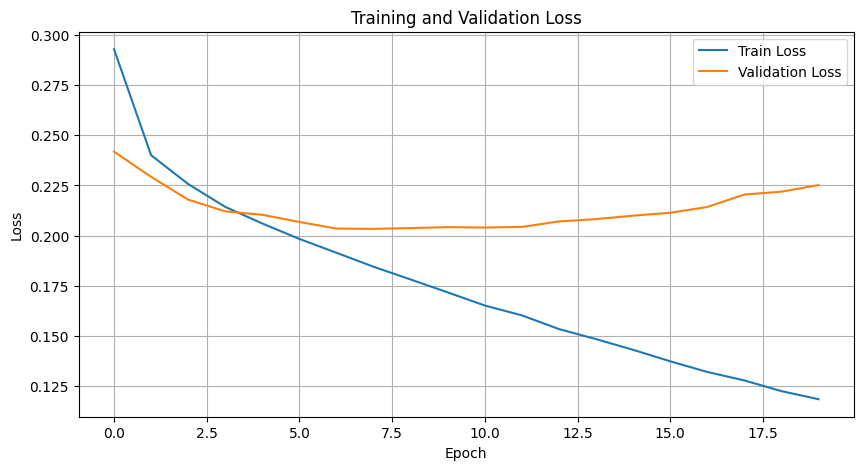

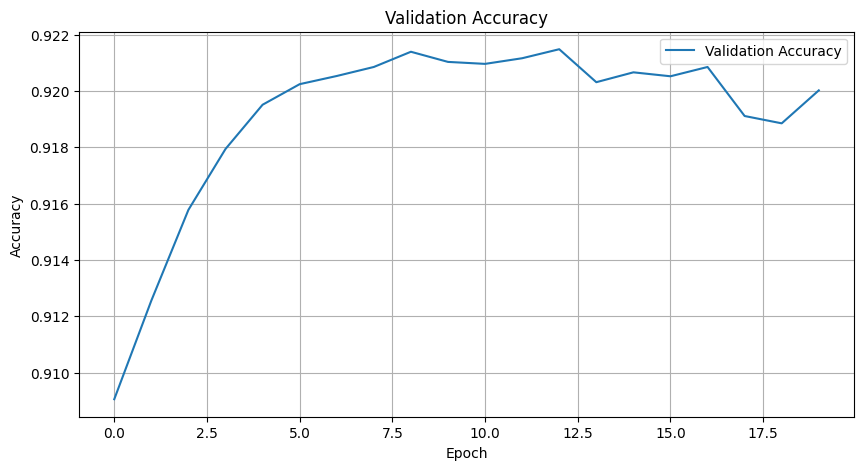

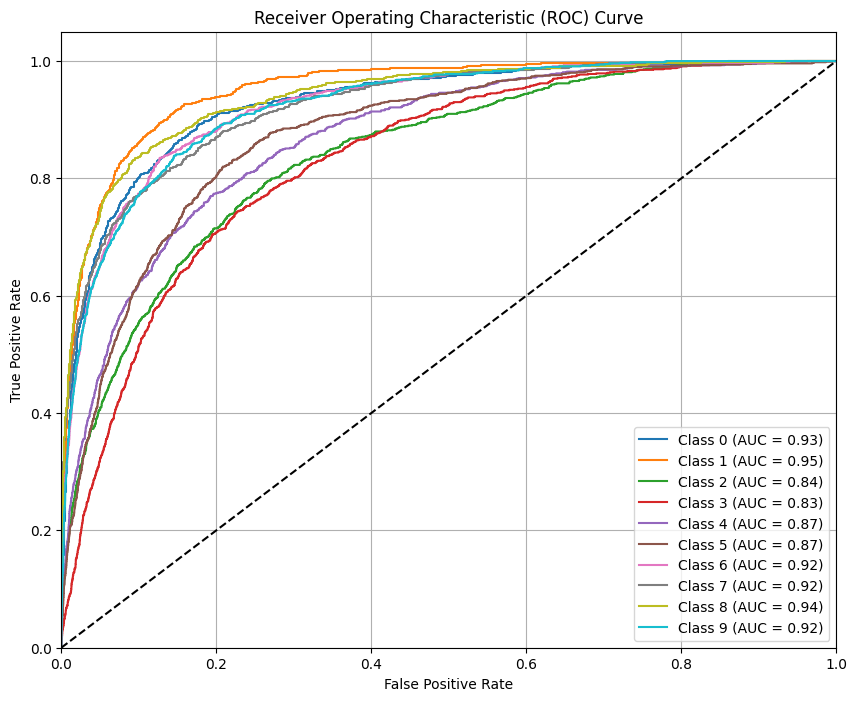

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets  # 导入 datasets 模块，用于加载数据集
import numpy as np
import os  # 导入 os 模块，用于处理文件路径
import matplotlib.pyplot as plt  # 导入绘图库，用于可视化结果
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc  # 导入评估指标，用于模型评估
import seaborn as sns  # 导入 seaborn，用于美化图表

# 1. 定义 PLE 模型 (保持不变)
class Expert(nn.Module):
    """
    专家网络模块。
    """

    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        """
        初始化专家网络。

        Args:
            input_dim (int): 输入维度。
            hidden_units (list of int): 隐藏层单元数量列表。
            activation (str): 激活函数类型，默认为 'relu'。
            dropout (float): dropout 概率，默认为 0。
            use_bn (bool): 是否使用批量归一化，默认为 False。
            init_std (float): 参数初始化标准差，默认为 1e-4。
        """
        super().__init__()
        self.layers = nn.ModuleList()
        input_size = input_dim
        for units in hidden_units:
            self.layers.append(nn.Linear(input_size, units))  # 添加线性层
            if use_bn:
                self.layers.append(nn.BatchNorm1d(units))  # 添加批量归一化
            if activation == 'relu':
                self.layers.append(nn.ReLU())  # 添加 ReLU 激活函数
            elif activation == 'gelu':
                self.layers.append(nn.GELU())  # 添加 GELU 激活函数
            if dropout > 0:
                self.layers.append(nn.Dropout(dropout))  # 添加 Dropout 层
            input_size = units  # 更新输入维度，供下一层使用

        # 参数初始化
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=init_std)  # 使用正态分布初始化权重
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)  # 将偏置初始化为 0

    def forward(self, x):
        """
        前向传播。

        Args:
            x (torch.Tensor): 输入张量。

        Returns:
            torch.Tensor: 输出张量。
        """
        for layer in self.layers:
            x = layer(x)  # 逐层传递
        return x


class CGCLayer(nn.Module):
    """
    自定义门控组合层（CGC）模块。
    """

    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        """
        初始化 CGC 层。

        Args:
            input_dim (int): 输入维度。
            num_tasks (int): 任务数量。
            shared_expert_num (int): 共享专家数量。
            specific_expert_num (int): 特定专家数量。
            expert_hidden_units (list of int): 专家网络的隐藏层单元数量列表。
            gate_hidden_units (list of int): 门控网络的隐藏层单元数量列表。
            activation (str): 激活函数类型，默认为 'relu'。
            dropout (float): dropout 概率，默认为 0。
            use_bn (bool): 是否使用批量归一化，默认为 False。
            init_std (float): 参数初始化标准差，默认为 1e-4。
        """
        super().__init__()
        self.num_tasks = num_tasks
        self.shared_expert_num = shared_expert_num
        self.specific_expert_num = specific_expert_num
        self.expert_hidden_units = expert_hidden_units  # 存储专家网络的隐藏单元数量

        # 任务特定专家
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
                for _ in range(specific_expert_num)
            ]) for _ in range(num_tasks)
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
            for _ in range(shared_expert_num)
        ])

        # 门控网络 - adjust input dim based on expert hidden units
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 输入维度需要与专家网络输出一致
        self.gates = nn.ModuleList([
            nn.Sequential(
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

        # 共享门控网络 - adjust input dim based on expert hidden units
        self.shared_gate = nn.Sequential(
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),
            nn.Softmax(dim=-1)
        )

    def forward(self, task_inputs, shared_input):
        """
        CGC 层的前向传播。

        Args:
            task_inputs (list of torch.Tensor): 每个任务的输入列表。
            shared_input (torch.Tensor): 共享输入。

        Returns:
            tuple of (list of torch.Tensor, torch.Tensor): 包含每个任务的输出和共享输出的元组。
        """
        # 任务特定专家输出
        task_expert_outputs = []
        for i in range(self.num_tasks):
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 使用task_inputs[i]而不是shared_input
            task_expert_outputs.extend(task_experts)

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]

        # 任务门控
        task_outputs = []
        for i in range(self.num_tasks):
            # 组合专家输出
            experts = task_expert_outputs[i * self.specific_expert_num:(i + 1) * self.specific_expert_num]
            experts += shared_expert_outputs
            expert_tensor = torch.stack(experts, dim=1)  # [B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # [B, num_experts]  输入更改为task_inputs[i]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            task_outputs.append(weighted_output)

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs
        expert_tensor = torch.stack(all_experts, dim=1)  # [B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)

        return task_outputs, shared_output


class PLE(nn.Module):
    """
    渐进式分层抽取网络（PLE）模型。
    """

    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        """
        初始化 PLE 模型。

        Args:
            input_dim (int): 输入维度。
            num_tasks (int): 任务数量。
            num_levels (int): CGC 层的数量，默认为 2。
            shared_expert_num (int): 共享专家数量，默认为 1。
            specific_expert_num (int): 特定专家数量，默认为 1。
            expert_hidden_units (tuple of int): 专家网络的隐藏层单元数量列表，默认为 (256,)。
            tower_hidden_units (tuple of int): 塔网络的隐藏层单元数量列表，默认为 (64,)。
            gate_hidden_units (tuple of int): 门控网络的隐藏层单元数量列表，默认为 ()。
            activation (str): 激活函数类型，默认为 'relu'。
            dropout (float): dropout 概率，默认为 0。
            use_bn (bool): 是否使用批量归一化，默认为 False。
            task_types (tuple of str): 每个任务的类型（'binary' 或 'regression'），默认为 ('binary', 'binary')。
            init_std (float): 参数初始化标准差，默认为 1e-4。
        """
        super().__init__()
        self.num_tasks = num_tasks
        self.num_levels = num_levels

        # 构建多层 CGC
        self.cgc_layers = nn.ModuleList()
        for level in range(num_levels):
            self.cgc_layers.append(
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1],
                    # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList()
        for i in range(num_tasks):
            tower = nn.Sequential(
                Expert(
                    input_dim=expert_hidden_units[-1],  # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1)  # 线性层输入
            )
            self.towers.append(tower)

        # 输出激活函数
        self.task_activations = nn.ModuleList([
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()
            for task_type in task_types
        ])

    def forward(self, x):
        """
        PLE 模型的前向传播。

        Args:
            x (torch.Tensor): 输入张量。

        Returns:
            torch.Tensor: 模型输出张量。
        """
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]
        shared_input = x.clone()

        # 逐层处理
        for cgc_layer in self.cgc_layers:
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input

        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            logit = self.towers[i](task_inputs[i])
            output = self.task_activations[i](logit)
            outputs.append(output)

        return torch.cat(outputs, dim=1)


# 2. CIFAR-10 数据集加载和预处理
def load_cifar10(batch_size, img_size=32):
    """
    加载 CIFAR-10 数据集并进行预处理。

    Args:
        batch_size (int): 批量大小。
        img_size (int): 图像大小，默认为 32。

    Returns:
        tuple of (DataLoader, DataLoader): 训练集和测试集的数据加载器。
    """
    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # 如果需要，可以调整大小
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 加载训练集
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # 加载测试集
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader


## 3. 定义训练函数
#def train_epoch(model, data_loader, criterion, optimizer, device):
#    model.train()
#    running_loss = 0.0
#    for batch_idx, (images, labels) in enumerate(data_loader):
#        images = images.to(device)
#        # 将标签转换为 one-hot 编码，然后转换为 float32
#        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
#        optimizer.zero_grad()
#        outputs = model(images)
#        loss = criterion(outputs, labels_onehot)  #  计算 loss
#        loss.backward()
#        optimizer.step()
#        running_loss += loss.item()
#
#    epoch_loss = running_loss / len(data_loader)
#    return epoch_loss
#
#

# 3. 定义训练函数
def train_epoch(model, data_loader, criterion, optimizer, device):
    """
    训练一个 epoch。

    Args:
        model (nn.Module): 模型。
        data_loader (DataLoader): 数据加载器。
        criterion (nn.Module): 损失函数。
        optimizer (torch.optim.Optimizer): 优化器。
        device (torch.device): 设备。

    Returns:
        float: 训练集的平均损失。
    """
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        # 将标签转换为 one-hot 编码，然后转换为 float32
        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
        optimizer.zero_grad()

        # Reshape images to match the input dimension of the model
        images = images.view(images.size(0), -1) # Flatten the images correctly

        outputs = model(images)
        loss = criterion(outputs, labels_onehot)  #  计算 loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader)
    return epoch_loss


def evaluate(model, data_loader, criterion, device, num_classes=10):
    """
    评估模型。

    Args:
        model (nn.Module): 模型。
        data_loader (DataLoader): 数据加载器。
        criterion (nn.Module): 损失函数。
        device (torch.device): 设备。
        num_classes (int): 类别数量，默认为 10。

    Returns:
        tuple of (float, float, float, float, float, np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict, dict, dict):
        包含评估结果的元组，包括损失、准确率、精确率、召回率、F1 值、每个类别的准确率、每个类别的精确率、每个类别的召回率、
        每个类别的 F1 值、ROC 曲线的 FPR、TPR 和 AUC 值。
    """
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    all_outputs = []  # 存储模型的原始输出 (logits)

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(device)

            # Reshape images for evaluation
            images = images.view(images.size(0), -1)

            outputs = model(images)
            loss = criterion(outputs, labels_onehot)
            running_loss += loss.item()

            # 将预测结果和标签转换为numpy数组
            predictions = (outputs > 0.5).int()  # 使用 0.5 作为阈值进行二分类
            all_labels.append(labels_onehot.cpu().numpy())  # 使用 one-hot 编码的标签
            all_predictions.append(predictions.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())  # 存储原始输出 (logits)

    epoch_loss = running_loss / len(data_loader)
    all_labels = np.concatenate(all_labels, axis=0)  # (样本数, num_classes)
    all_predictions = np.concatenate(all_predictions, axis=0)  # (样本数, num_classes)
    all_outputs = np.concatenate(all_outputs, axis=0)  # (样本数, num_classes)

    # 计算各种指标，针对多任务二分类
    accuracy = (all_predictions == all_labels).mean()  # 计算整体准确率 (所有任务)
    precision = precision_score(all_labels.ravel(), all_predictions.ravel())
    recall = recall_score(all_labels.ravel(), all_predictions.ravel())
    f1 = f1_score(all_labels.ravel(), all_predictions.ravel())

    # 计算每个类别的指标
    per_class_accuracy = (all_predictions == all_labels).mean(axis=0)  # 每个类别的准确率
    per_class_precision = precision_score(all_labels, all_predictions, average=None)
    per_class_recall = recall_score(all_labels, all_predictions, average=None)
    per_class_f1 = f1_score(all_labels, all_predictions, average=None)

    # 计算 ROC 和 AUC (每个类别)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_outputs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return epoch_loss, accuracy, precision, recall, f1, per_class_accuracy, per_class_precision, per_class_recall, per_class_f1, fpr, tpr, roc_auc


# 4. 主函数
if __name__ == "__main__":
    #  设置超参数
    img_size = 32  # 图像大小
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 20  # 训练轮数
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # CIFAR-10 相关设置
    num_classes = 10  # CIFAR-10 的类别数量
    num_tasks = num_classes  # 每个类别作为一个任务

    # 加载数据集
    train_loader, test_loader = load_cifar10(batch_size, img_size)

    # 初始化模型
    input_dim = 3 * img_size * img_size  #  根据图像大小计算输入维度
    model = PLE(
        input_dim=input_dim,
        num_tasks=num_tasks,
        num_levels=2,
        shared_expert_num=1,
        specific_expert_num=1,
        expert_hidden_units=(256, 128),
        tower_hidden_units=(64,),
        gate_hidden_units=(128,),
        dropout=0.2,
        use_bn=True,
        task_types=['binary'] * num_tasks,  #  每个任务都是二分类
    ).to(device)

    # 定义损失函数和优化器
    criterion = nn.BCELoss()  # 二元交叉熵损失
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 训练循环
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, accuracy, precision, recall, f1, per_class_accuracy, per_class_precision, per_class_recall, per_class_f1, fpr, tpr, roc_auc = evaluate(
            model, test_loader, criterion, device, num_classes
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)  # 存储整体准确率

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"  Per-Class Accuracy: {per_class_accuracy}")
        print(f"  Per-Class Precision: {per_class_precision}")
        print(f"  Per-Class Recall: {per_class_recall}")

    print("Training finished!")

    # 5. 绘制图表
    # 5.1 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5.2 绘制准确率曲线
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5.3 绘制 ROC 曲线
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [8]:
!pip install torchinfo

In [9]:
from torchinfo import summary
# 打印模型结构
input_size = (batch_size, input_dim)  # 定义输入张量的形状，batch_size 是批次大小，input_dim 是输入特征的维度
print(summary(model, input_size=input_size, col_names=["input_size", "output_size", "num_params", "mult_adds"])) # 使用 torchinfo 库打印模型结构摘要，包括输入大小、输出大小、参数数量和乘加运算次数


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
PLE                                                     [128, 3072]               [128, 10]                 --                        --
├─ModuleList: 1-1                                       --                        --                        --                        --
│    └─CGCLayer: 2-1                                    [128, 3072]               [128, 128]                --                        --
│    │    └─ModuleList: 3-1                             --                        --                        8,203,520                 --
│    │    └─ModuleList: 3-2                             --                        --                        820,352                   --
│    │    └─ModuleList: 3-3                             --                        --                        3,938,580                 --
│    │    └─Sequential: 3-4       

In [10]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 706.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [11]:
from torchviz import make_dot  # 导入 torchviz 库，用于绘制模型结构图
# 绘制模型结构图
# 创建一个 dummy input
dummy_input = torch.randn(batch_size, input_dim).to(device) # 创建一个随机输入张量，模拟模型的输入。batch_size 表示批次大小，input_dim 表示输入特征的维度
#  如果你的模型有多个输入，你需要相应地构造 dummy input
out = model(dummy_input) # 将 dummy input 传递给模型，获得模型的输出
dot = make_dot(out, params=dict(model.named_parameters())) # 使用 torchviz 生成模型结构图。'out' 是模型的输出，'params' 是模型的参数
dot.render("ple_model", format="png")  # 将模型结构图保存为 png 图片，文件名为 "ple_model.png"
print("Model graph saved as ple_model.png") # 打印消息，提示模型结构图已保存


Model graph saved as ple_model.png
